<br>
# **시계열 분석을 활용한 주가예측**
1. Stock Price Prediction Problem
1. source : https://github.com/scorpionhiccup/StockPricePrediction/tree/master/scripts
1. python : https://www.quantinsti.com/blog/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/

<br><br>
## **1. Loading and Handling Data into Pandas**
<br>
### ** 01 주가 데이터 불러오기**
googlefinance.get

[*********************100%***********************]  1 of 1 downloaded


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc001fd6668>,
      dtype=object)

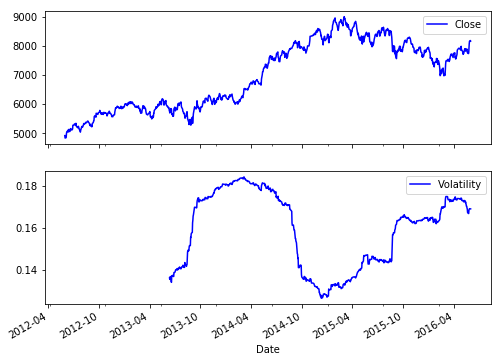

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from googlefinance.get import get_data_yahoo

NIFTY = get_data_yahoo('^NSEI','2012-06-01','2016-06-01')
NIFTY['Log_Ret']    = np.log(NIFTY['Close'] / NIFTY['Close'].shift(1))          # 종가를 이용한 Log 변동률 계산
NIFTY['Volatility'] = NIFTY['Log_Ret'].rolling(window=252).std() * np.sqrt(252) # 종가의 연간 이동표준편차 계산
NIFTY[['Close', 'Volatility']].plot(subplots=True, color='blue',figsize=(8, 6))

<br>
### ** 02 리스트 변동성에 근거한 변동 Sharp Ratio 계산**
1. Measures of risk-adjusted return based on volatility Sharpe ratio
1. Sharpe ratio = (Mean return − Risk-free rate) / Standard deviation of return

In [3]:
# Sharpe Ratio 
import numpy as np
def sharpe(returns, rf, days=252):
    volatility   = returns.std() * np.sqrt(days) 
    sharpe_ratio = (returns.mean() - rf) / volatility
    return sharpe_ratio

In [4]:
# 정보비율Information ratio (IR)
# 초과수익률과 적극적인 활동에 따른 수익률의 표준편차의 비율
# 이 비율이 높을수록 더 좋은 투자활동으로 판단된다
# http://www.funddoctor.co.kr/board/aboard/lecture_method_view.jsp?number=18

import numpy as np
def information_ratio(returns, benchmark_returns, days=252):
    return_difference = returns - benchmark_returns 
    volatility        = return_difference.std() * np.sqrt(days) 
    information_ratio = return_difference.mean() / volatility
    return information_ratio

In [5]:
# Modigliani Ratio
import numpy as np
def modigliani_ratio(returns, benchmark_returns, rf, days=252):
    volatility   = returns.std() * np.sqrt(days) 
    sharpe_ratio = (returns.mean() - rf) / volatility 
    benchmark_volatility = benchmark_returns.std() * np.sqrt(days)
    m2_ratio     = (sharpe_ratio * benchmark_volatility) + rf
    return m2_ratio

<br><br>
## **2. Loading and Handling Data into Pandas**
<br>
### ** 01 주가 데이터 불러오기**
Facebook 과 S&P500 지수 데이터 결합하기

1. https://stackoverflow.com/questions/43284304/how-to-compute-volatility-standard-deviation-in-rolling-window-in-pandas
1. prev_day_diff      : # Series.diff(periods=1) 
1. 50_day_moving_avg  : # Series.rolling(50).mean()
1. 10_day_volatility  : # volList = Ser.rolling(window=10).std(ddof=0)

In [7]:
import numpy as np
import pandas as pd
from googlefinance.get import get_data_yahoo
code = 'FB'

snp = get_data_yahoo('^GSPC','2012-06-01','2016-06-01')
snp = snp.iloc[:,[0,1,2,3,5,4]]
snp.columns = ['s&p_index_open', 's&p_index_high', 's&p_index_low', 's&p_index_close', 's&p_index_volume', 's&p_index_adj_close']

data = get_data_yahoo(code ,'2012-06-01','2016-06-01')
data = data.iloc[:,[0,1,2,3,5,4]]
data.columns              = [col.lower() for col in data.columns]
data['prev_day_diff']     = data.close.diff(periods=1)
data['50_day_moving_avg'] = data.close.rolling(50).mean()
data['10_day_volatility'] = data.close.rolling(10).std(ddof=0)
data = pd.concat([data, snp], axis=1)
data.insert(0, 'symbol', code)
print(data.head(3))

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
           symbol       open   high        low      close     volume  \
Date                                                                   
2012-05-31     FB  28.549999  29.67  26.830000  29.600000  111639200   
2012-06-01     FB  28.889999  29.15  27.389999  27.719999   41855500   
2012-06-04     FB  27.200001  27.65  26.440001  26.900000   35230300   

            adj close  prev_day_diff  50_day_moving_avg  10_day_volatility  \
Date                                                                         
2012-05-31  29.600000            NaN                NaN                NaN   
2012-06-01  27.719999      -1.880001                NaN                NaN   
2012-06-04  26.900000      -0.819999                NaN                NaN   

            s&p_index_open  s&p_index_high  s&p_index_low  s&p_index_close  \
Date                          

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2012-05-31 to 2016-05-31
Data columns (total 16 columns):
symbol                 1006 non-null object
open                   1006 non-null float64
high                   1006 non-null float64
low                    1006 non-null float64
close                  1006 non-null float64
volume                 1006 non-null int64
adj close              1006 non-null float64
prev_day_diff          1005 non-null float64
50_day_moving_avg      957 non-null float64
10_day_volatility      997 non-null float64
s&p_index_open         1006 non-null float64
s&p_index_high         1006 non-null float64
s&p_index_low          1006 non-null float64
s&p_index_close        1006 non-null float64
s&p_index_volume       1006 non-null int64
s&p_index_adj_close    1006 non-null float64
dtypes: float64(13), int64(2), object(1)
memory usage: 133.6+ KB


Reading as datetime format:

In [9]:
#check datatype of index
data.index

DatetimeIndex(['2012-05-31', '2012-06-01', '2012-06-04', '2012-06-05',
               '2012-06-06', '2012-06-07', '2012-06-08', '2012-06-11',
               '2012-06-12', '2012-06-13',
               ...
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-23', '2016-05-24', '2016-05-25', '2016-05-26',
               '2016-05-27', '2016-05-31'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)

In [10]:
#convert to time series:
ts = data['adj close']
ts.head(10)

Date
2012-05-31    29.600000
2012-06-01    27.719999
2012-06-04    26.900000
2012-06-05    25.870001
2012-06-06    26.809999
2012-06-07    26.309999
2012-06-08    27.100000
2012-06-11    27.010000
2012-06-12    27.400000
2012-06-13    27.270000
Name: adj close, dtype: float64

### Indexing TS arrays:

In [11]:
#1. Specific the index as a string constant:
ts['2012-09-18']

21.870001000000002

In [12]:
#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(2015, 3, 26)]

83.010002

#Get range:

In [13]:
#1. Specify the entire range:
ts['2012-08-18':'2015-03-26']

Date
2012-08-20    20.010000
2012-08-21    19.160000
2012-08-22    19.440001
2012-08-23    19.440001
2012-08-24    19.410000
2012-08-27    19.150000
2012-08-28    19.340000
2012-08-29    19.100000
2012-08-30    19.090000
2012-08-31    18.059999
2012-09-04    17.730000
2012-09-05    18.580000
2012-09-06    18.959999
2012-09-07    18.980000
2012-09-10    18.809999
2012-09-11    19.430000
2012-09-12    20.930000
2012-09-13    20.709999
2012-09-14    22.000000
2012-09-17    21.520000
2012-09-18    21.870001
2012-09-19    23.290001
2012-09-20    22.590000
2012-09-21    22.860001
2012-09-24    20.790001
2012-09-25    20.280001
2012-09-26    20.620001
2012-09-27    20.320000
2012-09-28    21.660000
2012-10-01    21.990000
                ...    
2015-02-12    76.230003
2015-02-13    75.739998
2015-02-17    75.599998
2015-02-18    76.709999
2015-02-19    79.419998
2015-02-20    79.900002
2015-02-23    78.839996
2015-02-24    78.449997
2015-02-25    79.559998
2015-02-26    80.410004
2015-02-27 

In [14]:
#2. Use ':' if one of the indices is at ends:
ts[:'2015-03-26']

Date
2012-05-31    29.600000
2012-06-01    27.719999
2012-06-04    26.900000
2012-06-05    25.870001
2012-06-06    26.809999
2012-06-07    26.309999
2012-06-08    27.100000
2012-06-11    27.010000
2012-06-12    27.400000
2012-06-13    27.270000
2012-06-14    28.290001
2012-06-15    30.010000
2012-06-18    31.410000
2012-06-19    31.910000
2012-06-20    31.600000
2012-06-21    31.840000
2012-06-22    33.049999
2012-06-25    32.060001
2012-06-26    33.099998
2012-06-27    32.230000
2012-06-28    31.360001
2012-06-29    31.100000
2012-07-02    30.770000
2012-07-03    31.200001
2012-07-05    31.469999
2012-07-06    31.730000
2012-07-09    32.169998
2012-07-10    31.469999
2012-07-11    30.969999
2012-07-12    30.809999
                ...    
2015-02-12    76.230003
2015-02-13    75.739998
2015-02-17    75.599998
2015-02-18    76.709999
2015-02-19    79.419998
2015-02-20    79.900002
2015-02-23    78.839996
2015-02-24    78.449997
2015-02-25    79.559998
2015-02-26    80.410004
2015-02-27 

Note: ends included here

In [15]:
#All rows of 1962:
ts['2012']

Date
2012-05-31    29.600000
2012-06-01    27.719999
2012-06-04    26.900000
2012-06-05    25.870001
2012-06-06    26.809999
2012-06-07    26.309999
2012-06-08    27.100000
2012-06-11    27.010000
2012-06-12    27.400000
2012-06-13    27.270000
2012-06-14    28.290001
2012-06-15    30.010000
2012-06-18    31.410000
2012-06-19    31.910000
2012-06-20    31.600000
2012-06-21    31.840000
2012-06-22    33.049999
2012-06-25    32.060001
2012-06-26    33.099998
2012-06-27    32.230000
2012-06-28    31.360001
2012-06-29    31.100000
2012-07-02    30.770000
2012-07-03    31.200001
2012-07-05    31.469999
2012-07-06    31.730000
2012-07-09    32.169998
2012-07-10    31.469999
2012-07-11    30.969999
2012-07-12    30.809999
                ...    
2012-11-16    23.559999
2012-11-19    22.920000
2012-11-20    23.100000
2012-11-21    24.320000
2012-11-23    24.000000
2012-11-26    25.940001
2012-11-27    26.150000
2012-11-28    26.360001
2012-11-29    27.320000
2012-11-30    28.000000
2012-12-03 

# Checking for stationarity

## Plot the time-series

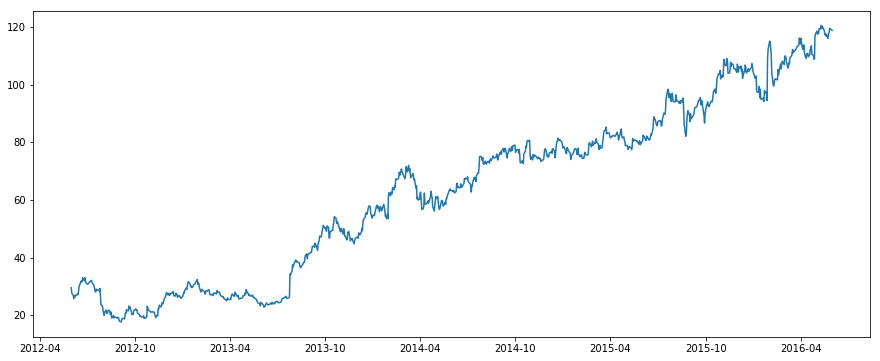

In [16]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.plot(ts)

### Function for testing stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=20)
    rolstd = pd.rolling_std(timeseries, window=20)

    #Plot rolling statistics:
    orig = plt.plot( timeseries, color = 'blue',  label = 'Original' )
    mean = plt.plot( rolmean,    color = 'red',   label = 'Rolling Mean' )
    std  = plt.plot( rolstd,     color = 'black', label = 'Rolling Std' )
    plt.legend( loc = 'best' )
    plt.title( 'Rolling Mean & Standard Deviation' )
    plt.show( block = False )
    
    #Perform Dickey-Fuller test:
    print ( 'Results of Dickey-Fuller Test:' )
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[ 0 : 4 ], index = ['open','high','10_day_volatility', '50_day_moving_avg'])
    for  key, value  in  dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


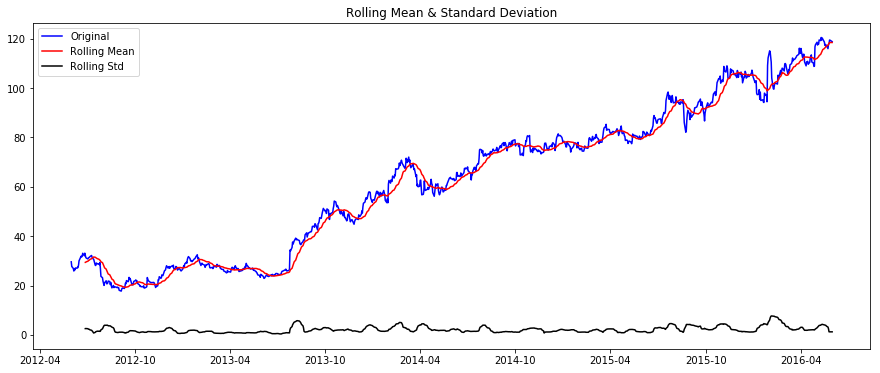

Results of Dickey-Fuller Test:
open                      0.182830
high                      0.971282
10_day_volatility         6.000000
50_day_moving_avg       999.000000
Critical Value (1%)      -3.436913
Critical Value (5%)      -2.864437
Critical Value (10%)     -2.568313
dtype: float64


In [18]:
test_stationarity(ts)

# Making Data Stationary


## Estimating & Eliminating Trend


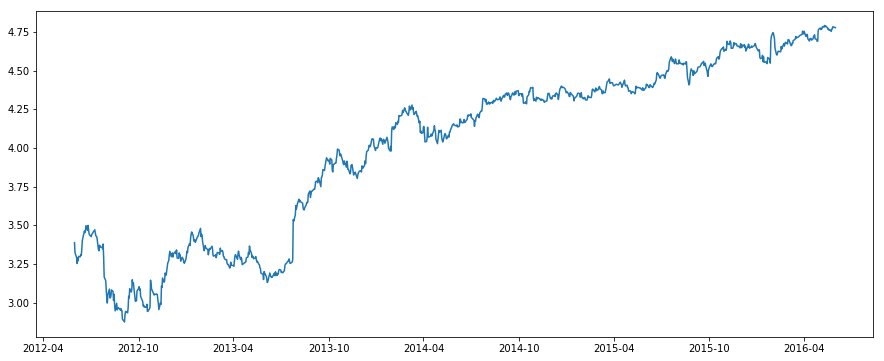

In [19]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Smoothing:

### Moving average

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,min_periods=1,center=False).mean()
  """Entry point for launching an IPython kernel.


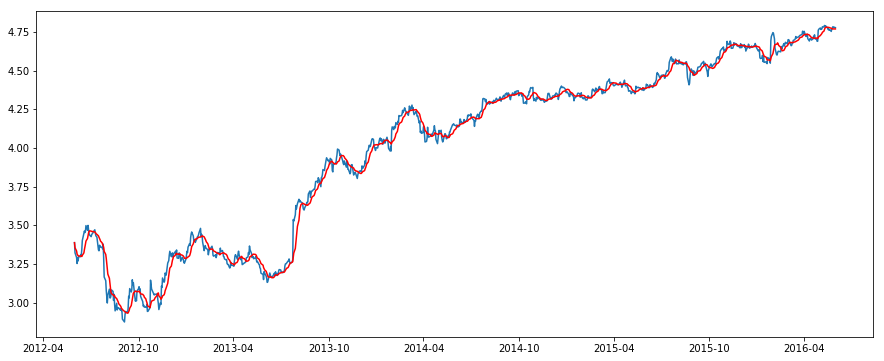

In [20]:
moving_avg = pd.rolling_mean(ts_log, 10, min_periods = 1)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [21]:
moving_avg[:3]

Date
2012-05-31    3.387774
2012-06-01    3.354964
2012-06-04    3.334018
Name: adj close, dtype: float64

In [22]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(15)

Date
2012-05-31    0.000000
2012-06-01   -0.032810
2012-06-04   -0.041892
2012-06-05   -0.060701
2012-06-06   -0.020008
2012-06-07   -0.032361
2012-06-08   -0.002380
2012-06-11   -0.004993
2012-06-12    0.008304
2012-06-13    0.003194
2012-06-14    0.044442
2012-06-15    0.095526
2012-06-18    0.125622
2012-06-19    0.120431
2012-06-20    0.094231
Name: adj close, dtype: float64

In [23]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Date
2012-05-31    0.000000
2012-06-01   -0.032810
2012-06-04   -0.041892
2012-06-05   -0.060701
2012-06-06   -0.020008
Name: adj close, dtype: float64

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


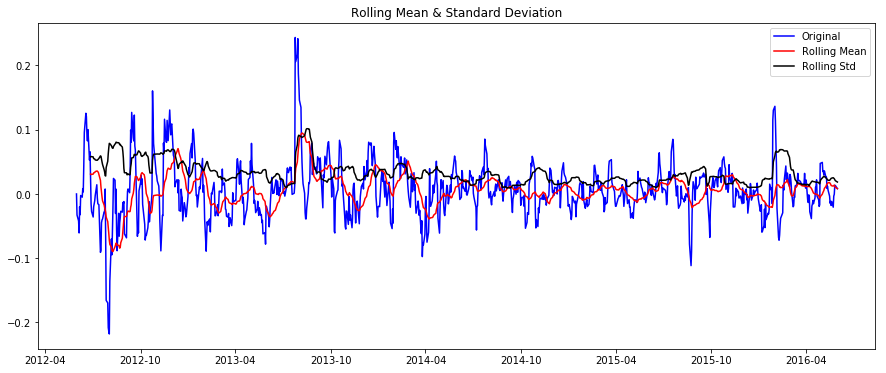

Results of Dickey-Fuller Test:
open                   -9.332130e+00
high                    9.267782e-16
10_day_volatility       6.000000e+00
50_day_moving_avg       9.990000e+02
Critical Value (1%)    -3.436913e+00
Critical Value (5%)    -2.864437e+00
Critical Value (10%)   -2.568313e+00
dtype: float64


In [24]:
test_stationarity(ts_log_moving_avg_diff)

### Exponentially Weighted Moving Average

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


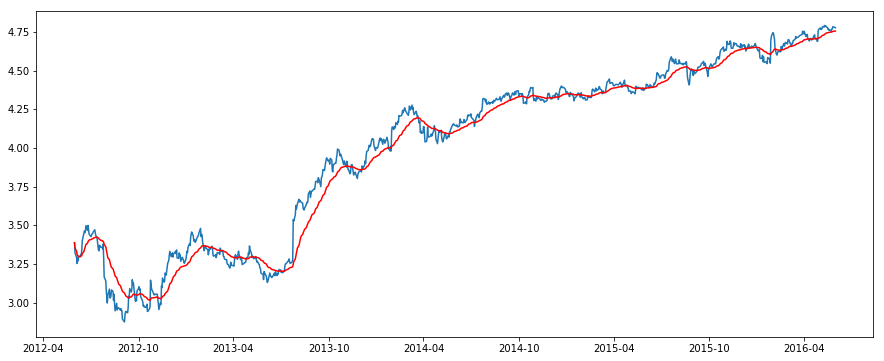

In [25]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


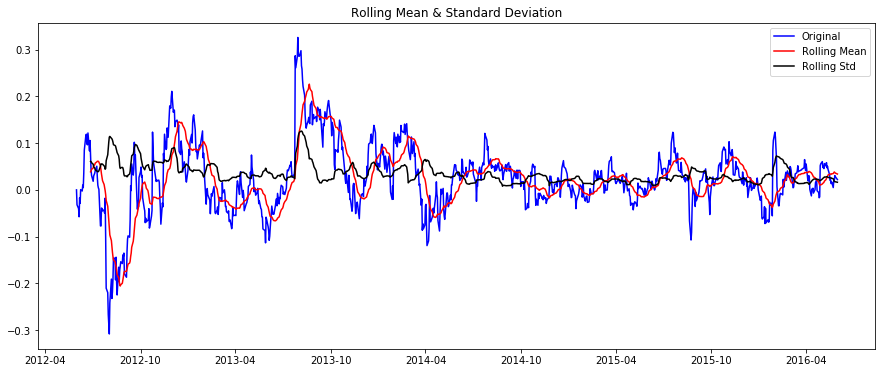

Results of Dickey-Fuller Test:
open                      -5.367323
high                       0.000004
10_day_volatility          0.000000
50_day_moving_avg       1005.000000
Critical Value (1%)       -3.436873
Critical Value (5%)       -2.864420
Critical Value (10%)      -2.568304
dtype: float64


In [26]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality

### Differencing:

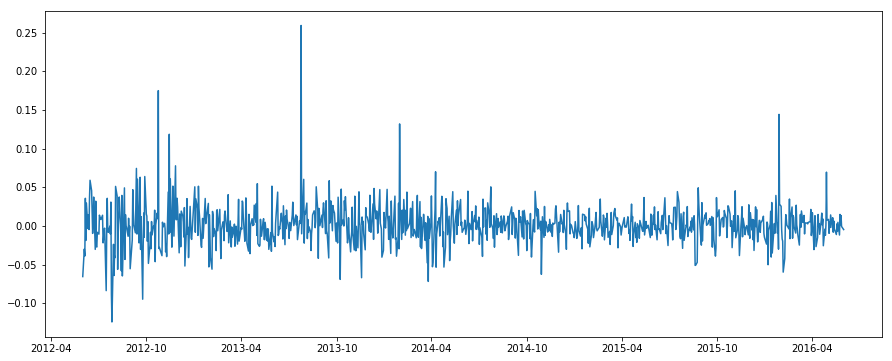

In [27]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


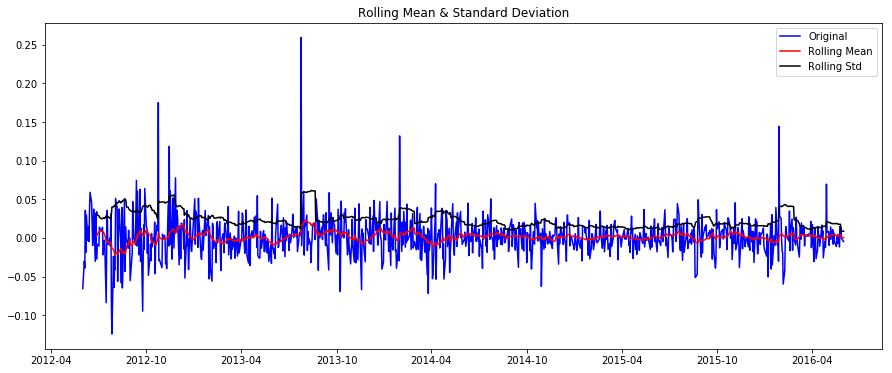

Results of Dickey-Fuller Test:
open                     -31.503194
high                       0.000000
10_day_volatility          0.000000
50_day_moving_avg       1004.000000
Critical Value (1%)       -3.436880
Critical Value (5%)       -2.864423
Critical Value (10%)      -2.568305
dtype: float64


In [28]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition:

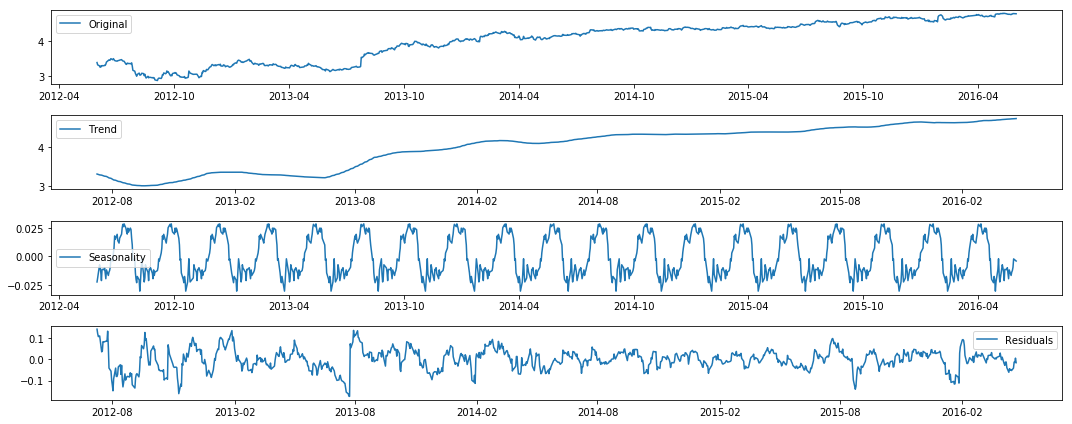

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=52)

trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


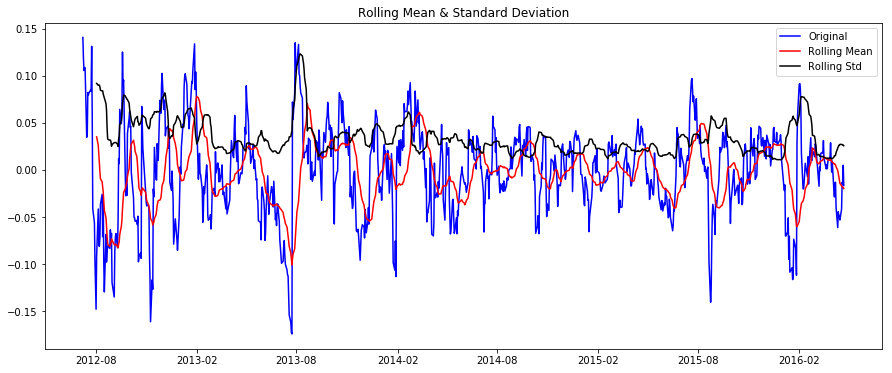

Results of Dickey-Fuller Test:
open                   -8.145501e+00
high                    1.001473e-12
10_day_volatility       7.000000e+00
50_day_moving_avg       9.460000e+02
Critical Value (1%)    -3.437281e+00
Critical Value (5%)    -2.864600e+00
Critical Value (10%)   -2.568399e+00
dtype: float64


In [30]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Final Forecasting

In [31]:
from statsmodels.tsa.arima_model import ARIMA

### ACF & PACF Plots

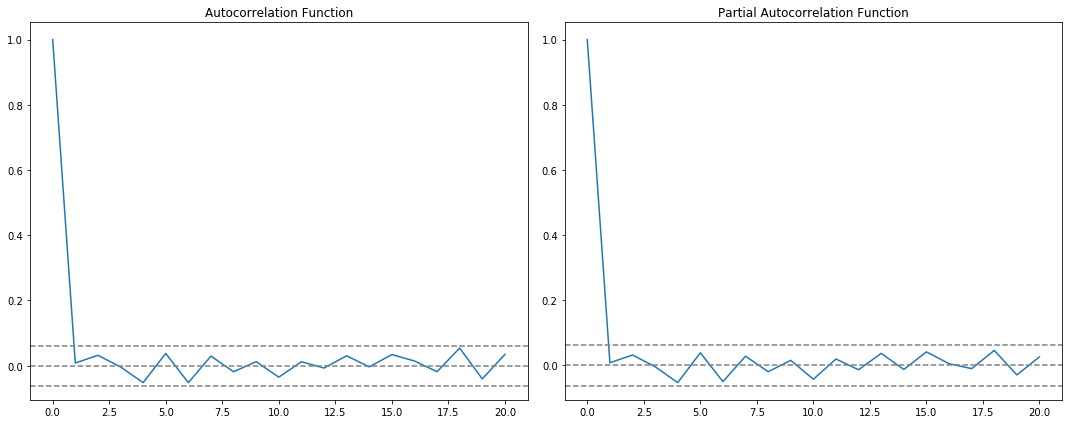

In [32]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### AR Model:

/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 0.6532')

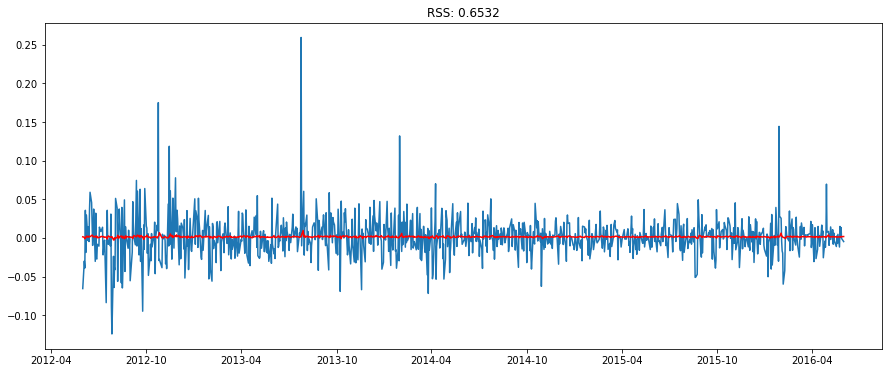

In [33]:
#MA model:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 0.6531')

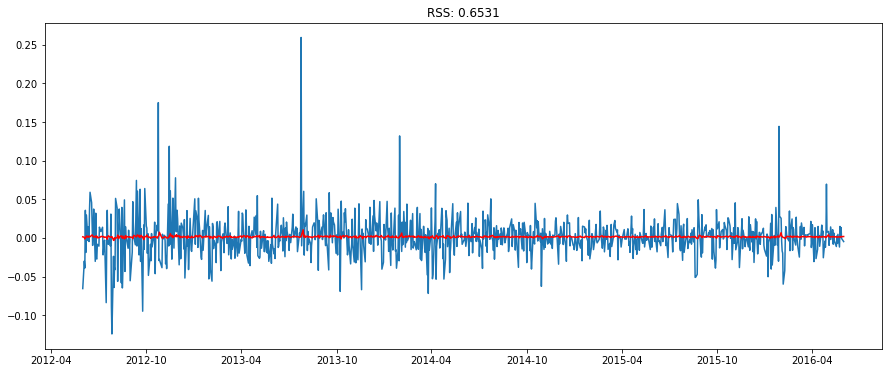

In [34]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### ARIMA Model:

/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/markbaum/Python/django/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversi

Text(0.5,1,'RSS (Root Squared Sum): 0.6520')

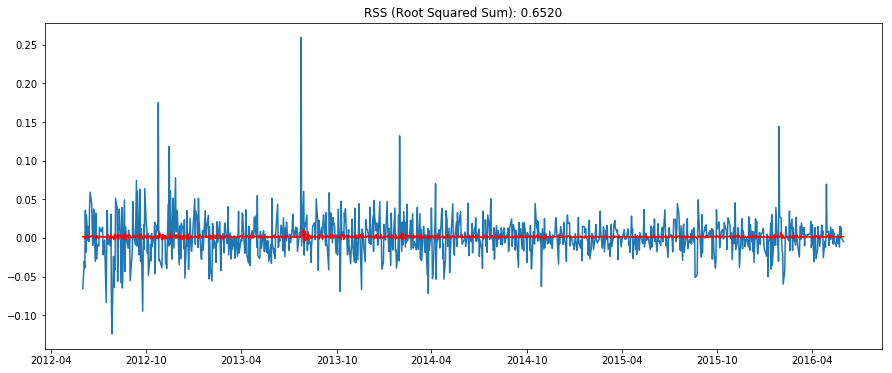

In [35]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS (Root Squared Sum): %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

### Convert to original scale:

In [36]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2012-06-01    0.001365
2012-06-04    0.001557
2012-06-05   -0.001021
2012-06-06    0.001727
2012-06-07    0.001218
dtype: float64

In [37]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2012-06-01    0.001365
2012-06-04    0.002921
2012-06-05    0.001900
2012-06-06    0.003628
2012-06-07    0.004845
dtype: float64

In [38]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

/home/markbaum/Python/django/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2012-05-31    3.387774
2012-06-01    3.389139
2012-06-04    3.390696
2012-06-05    3.389675
2012-06-06    3.391402
dtype: float64

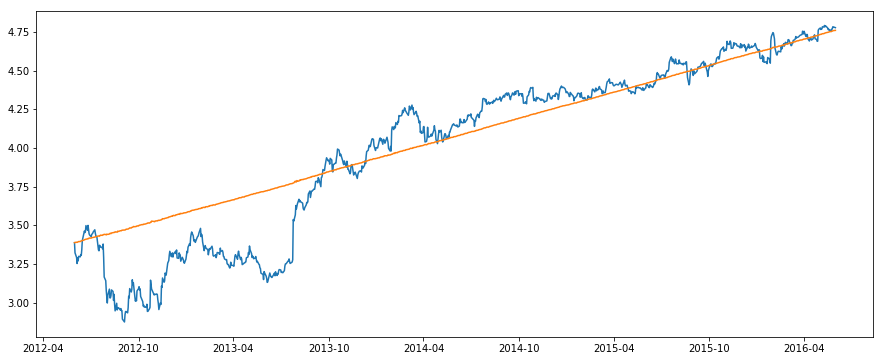

In [39]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

Text(0.5,1,'RMSE: 8.2444')

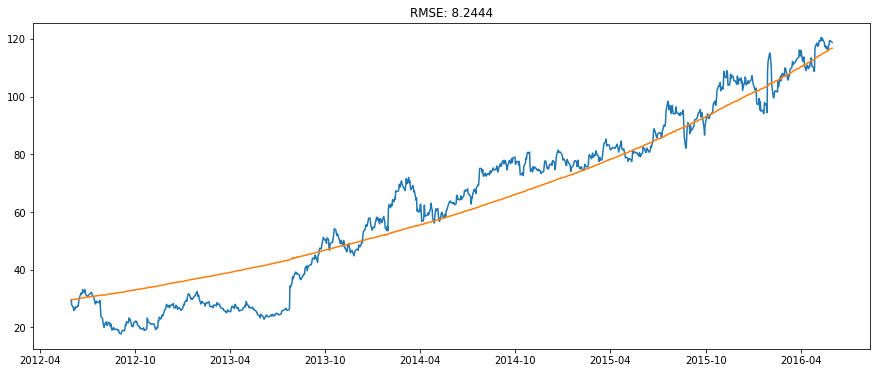

In [40]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))